In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

## Data

In [2]:
from hierarchical_generalization.make_datasets import generate_phase_train_test_data

train_data, test_data = generate_phase_train_test_data() 

print(train_data.keys(), test_data.keys())
print(train_data['Phase A'][0].shape, train_data['Phase A'][1].shape) # trials x color x shape

dict_keys(['Phase A', 'Phase B', 'Phase C']) dict_keys(['Phase A', 'Phase B', 'Phase C'])
(120, 5, 4) (120, 4)


In [3]:
train, target = train_data['Phase A']
trial = train[105]
trial

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 1., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [4]:
def onehot(data):
    """
    input: trials x color x shape
    output: trials x onehotcoding of color and shape
    """
    num_trials = data.shape[0]
    length = data.shape[1] + data.shape[2]
    one_hot = torch.zeros([num_trials, length])
    
    for i in range(num_trials):
        dim0 = data[i].sum(axis=0).argmax()
        dim1 = data[i].sum(axis=1).argmax()
        one_hot[i][dim0] = 1
        one_hot[i][data.shape[1] - 1 + dim1] = 1
        
    return one_hot

In [5]:
onehot(train)

tensor([[1., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [6]:
def phase_data(phase, batch_size=120):
    train_data, test_data = generate_phase_train_test_data()
    train, test = train_data[phase]
    train = onehot(train)
    test = torch.from_numpy(test)
    return train[:batch_size], test[:batch_size]

train, test = phase_data('Phase A')
print(train.size(), test.size()) # batch x features; batch x actions
print(train[7:11])
print(test[7:11])

torch.Size([120, 9]) torch.Size([120, 4])
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0.]])
tensor([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]], dtype=torch.float64)


In [7]:
train, test = phase_data('Phase A', batch_size=1)
print(train.size(), test.size()) # batch x features; batch x actions

torch.Size([1, 9]) torch.Size([1, 4])


## RNN

### Model

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=2)
    
    def init_hidden(self, batch_size):
        #h0 = torch.randn(self.num_layers, batch_size, self.hidden_size)
        #c0 = torch.randn(self.num_layers, batch_size, self.hidden_size)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return [h0, c0]
    
    def forward(self, x):
        hidden = self.init_hidden(x.size(1))
        steps = x.size(0) # squence length
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        #out = self.softmax(self.fc(out))
        return out

### Usage refresh

In [9]:
length = 10
input_size = 3
hidden_size = 20
batch_size = 2
num_layers = 1

h0 = torch.zeros(num_layers, batch_size, hidden_size)
c0 = torch.zeros(num_layers, batch_size, hidden_size)

x = torch.zeros(length, batch_size, input_size)

lstm_test = nn.LSTM(input_size, hidden_size)
out, hidd = lstm_test(x, [h0, c0])

print(out.size(), hidd[0].size(), hidd[1].size()) # out: length x batch x hidden

torch.Size([10, 2, 20]) torch.Size([1, 2, 20]) torch.Size([1, 2, 20])


### Helper functions

#### plot

In [10]:
def plot_loss(phase, all_losses):
    """
    all_losses must be an array
    """
    f, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Trials')
    ax.set_ylabel('Loss')
    ax.set_title(phase)
    for i in range(len(all_losses)):
        if all_losses[i] < 0.1:
            ax.text(i*0.9, all_losses[i]*1.4, s=(i, str(all_losses[i])[:4]))
            break
    ax.plot(all_losses)
    #ax.text(len(all_losses)*0.9, all_losses[-1]*1.2, s=str(all_losses[-1])[:5], alpha=0.9)

In [11]:
def plot_accuracy(phase, all_accus):
    """
    all_losses can be an array or a matrix
    """
    phases = ['Phase A', 'Phase B', 'Phase C']
    f, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Trials')
    ax.set_ylabel('Accuracy')
    ax.set_title(phase)
    ax.set_ylim([0, 1.1])
    ax.set_yticks(np.arange(0,1.1,0.2))
    ax.spines['top'].set_visible(False)  #去掉上边框
    ax.spines['right'].set_visible(False) #去掉右边框
    for j in range(all_accus.shape[-1]):
        all_accu = all_accus[:, j]
        for i in range(len(all_accu)):
            if all_accu[i] > 0.9:
                ax.text(i, all_accu[i], s=i)
                break
        ax.plot(all_accu, label=phases[j])
        ax.legend() #loc='upper right'

#### test overall generalization

In [12]:
def test_allphase(plot=False, ifprint=False):
    phases = ['Phase A', 'Phase B', 'Phase C']
    train_data, test_data = generate_phase_train_test_data()
    all_accu = []
    
    for phase in phases:
        test_input, test_target = test_data[phase]
        test_input = onehot(test_input)
        test_target = torch.from_numpy(test_target)

        with torch.no_grad():
            test_input = torch.unsqueeze(test_input, 0)
            output = lstm(test_input)
            output = torch.squeeze(output, 0)
            accuracy = (output.argmax(dim=1) == test_target.argmax(dim=1)).float()
            accuracy = accuracy.mean()
            all_accu.append(accuracy)
            if ifprint:
                print(f"Accuracy in {phase} is: {accuracy.item():.2%}")
        
    if plot:
        f, ax = plt.subplots(figsize=(4, 4))
        ax.bar(phases, all_accu, width=0.5)
        for i in range(3):
            ax.text(i, all_accu[i]*1.05, '%.3f' % all_accu[i], ha='center', va= 'bottom')
    
    return all_accu

#### test C0-C1 vs C2

In [13]:
from hierarchical_generalization.make_datasets import generate_taskset_test_data

# Outputs the taskset test data
ts_test_data = generate_taskset_test_data()
ts_test_data.keys()

dict_keys(['TS 1 Phase A', 'TS 2 Phase A', 'TS 1 Phase B', 'TS 2 Phase B', 'TS Old Phase C', 'TS New Phase C'])

In [14]:
TS_1_PhaseA = ts_test_data['TS 1 Phase A']
TS_2_PhaseA = ts_test_data['TS 2 Phase A']
TS_1_PhaseB = ts_test_data['TS 1 Phase B']
TS_2_PhaseB = ts_test_data['TS 2 Phase B']
TS_Old_PhaseC = ts_test_data['TS Old Phase C']
TS_New_PhaseC = ts_test_data['TS New Phase C']

In [15]:
def phase_test(phase, batch_size=120):
    ts_test_data = generate_taskset_test_data()
    train, target = ts_test_data[phase]
    train = onehot(train)
    target = torch.from_numpy(target)
    return train[:batch_size], target[:batch_size]

TS1_PhaseA_train, TS1_PhaseA_target = phase_test('TS 1 Phase A')
print(TS1_PhaseA_train.size(), TS1_PhaseA_target.size()) # batch x features; batch x actions

TS1_PhaseA_train, TS1_PhaseA_target = phase_test('TS 2 Phase A')
print(TS1_PhaseA_train.size(), TS1_PhaseA_target.size()) # batch x features; batch x actions

torch.Size([4, 9]) torch.Size([4, 4])
torch.Size([2, 9]) torch.Size([2, 4])


In [16]:
def test_C0C1vsC2(phase):
    """
    phase: 'Phase A' or 'Phase B'
    """
    TS1_train, TS1_target = phase_test('TS 1 '+phase)
    TS2_train, TS2_target = phase_test('TS 2 '+phase)

    TS1_accu = []
    TS2_accu = []

    with torch.no_grad():
        for i in range(TS1_target.size(0)):
            train = TS1_train[i:i+1]
            train = torch.unsqueeze(train, 0)
            output = lstm(train)
            output = torch.squeeze(output, 0)
            
            accuracy = (output.argmax(dim=1) == TS1_target[i:i+1].argmax(dim=1)).float()
            TS1_accu.append(accuracy.item())
            
        for i in range(TS2_target.size(0)):
            train = TS2_train[i:i+1]
            train = torch.unsqueeze(train, 0)
            output = lstm(train)
            output = torch.squeeze(output, 0)
            
            accuracy = (output.argmax(dim=1) == TS2_target[i:i+1].argmax(dim=1)).float()
            TS2_accu.append(accuracy.item())
            
            
    return (np.mean(TS1_accu), np.mean(TS2_accu))

#### test novel context

In [17]:
def test_OldvsNew():
    TS_Old_train, TS_Old_target = phase_test('TS Old Phase C')
    TS_New_train, TS_New_target = phase_test('TS New Phase C')
    Old_accu = []
    New_accu = []

    with torch.no_grad():
        for i in range(TS_Old_target.size(0)):
            train = TS_Old_train[i:i+1]
            train = torch.unsqueeze(train, 0)
            output = lstm(train)
            output = torch.squeeze(output, 0)
            
            accuracy = (output.argmax(dim=1) == TS_Old_target[i:i+1].argmax(dim=1)).float()
            Old_accu.append(accuracy.item())
            
        for i in range(TS_New_target.size(0)):
            train = TS_New_train[i:i+1]
            train = torch.unsqueeze(train, 0)
            output = lstm(train)
            output = torch.squeeze(output, 0)
            
            accuracy = (output.argmax(dim=1) == TS_New_target[i:i+1].argmax(dim=1)).float()
            New_accu.append(accuracy.item())
            
    return (np.mean(Old_accu), np.mean(New_accu))

## Run!!

### Model hyperparameters

In [18]:
BATCH_SIZE = 1

train, test = phase_data('Phase A', batch_size=BATCH_SIZE) # batch x features; batch x actions
input_size = train.size(1)
output_size = test.size(1)
hidden_size = 64

num_layers = 1
length = 1

lstm = LSTM(input_size, hidden_size, num_layers, output_size)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

### Initial train on phase A

In [19]:
def train_model(phase, transfer=True):
    current_loss = 0
    all_losses = []
    all_accu = []
    n_iters = 500
    T1_all_accu = []
    T2_all_accu = []

    for i in range(n_iters):
        train, test = phase_data(phase, batch_size=BATCH_SIZE)
        train = torch.unsqueeze(train, 0)

        output = lstm(train)
        output = torch.squeeze(output, 0)
        loss = criterion(output, test.argmax(axis=1))
        
        accuracy = test_allphase()
        all_accu.append([i.item() for i in accuracy])
        
        if phase != 'Phase C':
            TS1_accu, TS2_accu = test_C0C1vsC2(phase)
            T1_all_accu.append(TS1_accu)
            T2_all_accu.append(TS2_accu)
        else:
            Old_accu, New_accu = test_OldvsNew()
            T1_all_accu.append(Old_accu)
            T2_all_accu.append(New_accu)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        all_losses.append(loss.item())
        if all_losses[-1] <= 0.01:
            if transfer or i >= 200:
                break
    print(i)
    return all_losses, np.array(all_accu), np.array(T1_all_accu), np.array(T2_all_accu)

In [20]:
all_lossesA, all_accuA, T1_all_accuA, T2_all_accuA = train_model('Phase A', transfer=False)

200


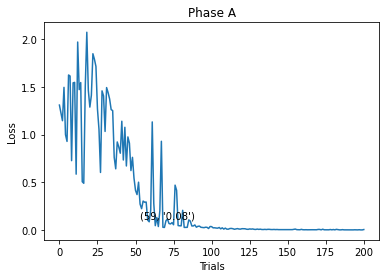

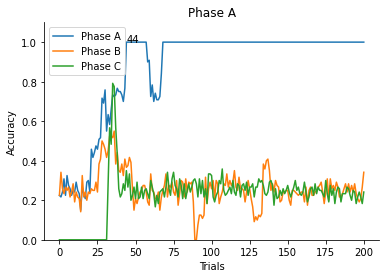

In [21]:
plot_loss('Phase A', all_lossesA)
plot_accuracy('Phase A', all_accuA)

### Overall transfer B and C

73


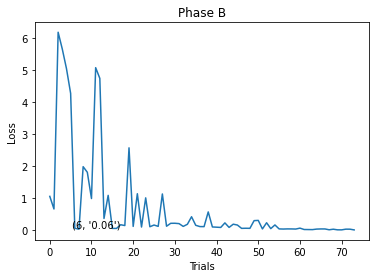

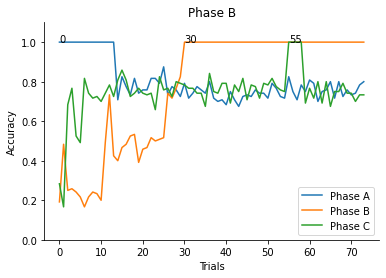

In [22]:
all_lossesB, all_accuB, T1_all_accuB, T2_all_accuB  = train_model('Phase B')
plot_loss('Phase B', all_lossesB)
plot_accuracy('Phase B', all_accuB)

14


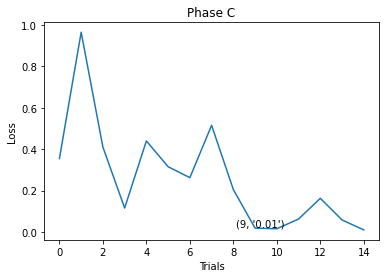

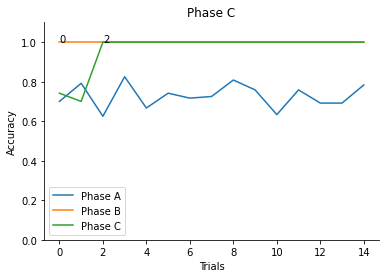

In [23]:
all_lossesC, all_accuC, Old_accu, New_accu = train_model('Phase C')
plot_loss('Phase C', all_lossesC)
plot_accuracy('Phase C', all_accuC)

### C0-C1 vs C2 in initital trained on A and transfer on B

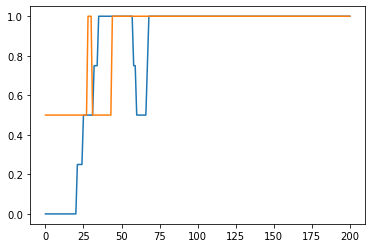

In [24]:
plt.plot(T1_all_accuA)
plt.plot(T2_all_accuA)

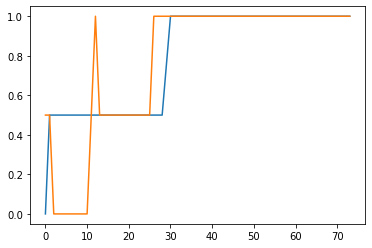

In [25]:
plt.plot(T1_all_accuB)
plt.plot(T2_all_accuB)

### Novel context

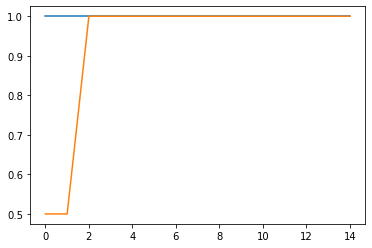

In [26]:
plt.plot(Old_accu)
plt.plot(New_accu)

### Learning curve

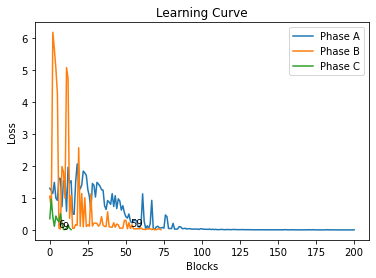

In [27]:
def plot_learningcurve(phases, all_losses):
    """
    all_losses can be an array or a matrix
    """
    f, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Blocks')
    ax.set_ylabel('Loss')
    ax.set_title("Learning Curve")
    for j in range(len(phases)):
        all_loss = all_losses[j]
        for i in range(len(all_loss)):
            if all_loss[i] < 0.1:
                ax.text(i*0.9, all_loss[i]*1.3, s=i)
                break
        ax.plot(all_loss, label=phases[j])
        ax.legend()
        
plot_learningcurve(['Phase A', 'Phase B', 'Phase C'], 
                   [all_lossesA, all_lossesB, all_lossesC])

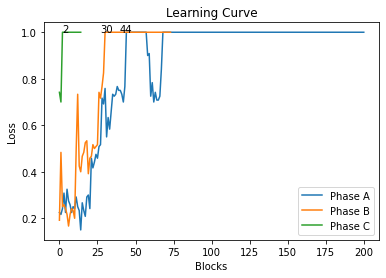

In [28]:
def plot_learning_accu_curve(phases, all_losses):
    """
    all_losses can be an array or a matrix
    """
    f, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Blocks')
    ax.set_ylabel('Loss')
    ax.set_title("Learning Curve")
    for j in range(len(phases)):
        all_loss = all_losses[j]
        for i in range(len(all_loss)):
            if all_loss[i] > 0.9:
                ax.text(i*0.9, all_loss[i], s=i)
                break
        ax.plot(all_loss, label=phases[j])
        ax.legend()
        
plot_learning_accu_curve(['Phase A', 'Phase B', 'Phase C'], 
                  [all_accuA[:, 0], all_accuB[:, 1], all_accuC[:, 2]])

### 100 subject

In [29]:
# all_data = {}

# all_data['all_lossesA'] = np.zeros([100, 200])
# all_data['all_accuAA'] = np.zeros([100, 200])
# all_data['all_accuAB'] = np.zeros([100, 200])
# all_data['all_accuAC'] = np.zeros([100, 200])
# all_data['T1_all_accuA'] = np.zeros([100, 200])
# all_data['T2_all_accuA'] = np.zeros([100, 200])

# all_data['all_lossesB'] = np.zeros([100, 200])
# all_data['all_accuBA'] = np.zeros([100, 200])
# all_data['all_accuBB'] = np.zeros([100, 200])
# all_data['all_accuBC'] = np.zeros([100, 200])
# all_data['T1_all_accuB'] = np.zeros([100, 200])
# all_data['T2_all_accuB'] = np.zeros([100, 200])

# all_data['all_lossesC'] = np.zeros([100, 200])
# all_data['all_accuCA'] = np.zeros([100, 200])
# all_data['all_accuCB'] = np.zeros([100, 200])
# all_data['all_accuCC'] = np.zeros([100, 200])
# all_data['Old_accu'] = np.zeros([100, 200])
# all_data['New_accu'] = np.zeros([100, 200])

# for i in range(100):
    
#     lstm = LSTM(input_size, hidden_size, num_layers, output_size)
#     optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)
#     criterion = nn.CrossEntropyLoss()
    
#     all_lossesA, all_accuA, T1_all_accuA, T2_all_accuA = train_model('Phase A', transfer=False)
#     all_lossesB, all_accuB, T1_all_accuB, T2_all_accuB  = train_model('Phase B', transfer=False)
#     all_lossesC, all_accuC, Old_accu, New_accu = train_model('Phase C', transfer=False)
    
#     all_data['all_lossesA'][i] = all_lossesA[:200]
#     all_data['all_accuAA'][i] = all_accuA[:200, 0]
#     all_data['all_accuAB'][i] = all_accuA[:200, 1]
#     all_data['all_accuAC'][i] = all_accuA[:200, 2]
#     all_data['T1_all_accuA'][i] = T1_all_accuA[:200]
#     all_data['T2_all_accuA'][i] = T2_all_accuA[:200]
    
#     all_data['all_lossesB'][i] = all_lossesB[:200]
#     all_data['all_accuBA'][i] = all_accuB[:200, 0]
#     all_data['all_accuBB'][i] = all_accuB[:200, 1]
#     all_data['all_accuBC'][i] = all_accuB[:200, 2]
#     all_data['T1_all_accuB'][i] = T1_all_accuB[:200]
#     all_data['T2_all_accuB'][i] = T2_all_accuB[:200]
    
#     all_data['all_lossesC'][i] = all_lossesC[:200]
#     all_data['all_accuCA'][i] = all_accuC[:200, 0]
#     all_data['all_accuCB'][i] = all_accuC[:200, 1]
#     all_data['all_accuCC'][i] = all_accuC[:200, 2]
#     all_data['Old_accu'][i] = Old_accu[:200]
#     all_data['New_accu'][i] = New_accu[:200]

# np.save('my_file.npy', all_data)

## Internal representation in ANN

In [30]:
lstm

LSTM(
  (lstm): LSTM(9, 64)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

### Get hidden activity

In [31]:
def get_hidden_activity(net, stimuli):
    """Retrieve internal representations of network

    Args:
      net (nn.Module): a NN model
      stimuli (torch.Tensor): batchsize x 1 x 128 x 128 tensor 

    Returns:
      dict: internal representations at each layer of the network, in
        numpy arrays. The keys of this dict are the strings in layer_labels.

    """
    feature_out = {}
    layers_name = list(net._modules.keys())
    layers = list(net._modules.values())

    def hook_fn_forward(module, input, output):
        # Attach 'hooks' to each layer of the network to store hidden representations in hidden_activity
        layer_name = layers_name[np.argwhere([module == m for m in layers])[0, 0]]
        feature_out[layer_name] = output
    
    handles = {}
    modules = net.named_children()
    for name, module in modules:
        handles[name] = module.register_forward_hook(hook_fn_forward)

    net.eval() 
    with torch.no_grad():
        pred = net(stimuli)
        for k, v in handles.items():
            handles[k].remove()
            
    return feature_out

In [32]:
TS_1_PhaseA = ts_test_data['TS 1 Phase A']
TS_2_PhaseA = ts_test_data['TS 2 Phase A']
TS_1_PhaseB = ts_test_data['TS 1 Phase B']
TS_2_PhaseB = ts_test_data['TS 2 Phase B']
TS_Old_PhaseC = ts_test_data['TS Old Phase C']
TS_New_PhaseC = ts_test_data['TS New Phase C']

In [33]:
ts_test_data = generate_taskset_test_data()
train, target = ts_test_data['TS 1 Phase A']
train = onehot(train)
x = train[0].unsqueeze(0).unsqueeze(0)
x.shape

torch.Size([1, 1, 9])

In [34]:
hidden_activity, [_ , _] = get_hidden_activity(lstm, x)['lstm']
hidden_activity = hidden_activity.squeeze(0).squeeze(0)
hidden_activity.shape

torch.Size([64])

In [35]:
TS1_PhaseA, _ = phase_test('TS 1 Phase A')
print(TS1_PhaseA.size()) 
TS2_PhaseA, _ = phase_test('TS 2 Phase A')
print(TS2_PhaseA.size()) 
TS1_PhaseB, _ = phase_test('TS 1 Phase B')
print(TS1_PhaseB.size()) 
TS2_PhaseB, _ = phase_test('TS 2 Phase B')
print(TS2_PhaseB.size()) 
Old_PhaseC, _ = phase_test('TS Old Phase C')
print(Old_PhaseC.size()) 
New_PhaseC, _ = phase_test('TS New Phase C')
print(New_PhaseC.size())

torch.Size([4, 9])
torch.Size([2, 9])
torch.Size([4, 9])
torch.Size([2, 9])
torch.Size([2, 9])
torch.Size([2, 9])


In [36]:
label = [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 2, 2, 3, 3]
len(label)

16

In [37]:
def get_hidden(data):
    num_stim = data.size(0)
    hidden = np.zeros([num_stim, 64])
    
    for i in range(num_stim):
        x = data[i].unsqueeze(0).unsqueeze(0)
        hidden_activity, [_ , _] = get_hidden_activity(lstm, x)['lstm']
        hidden[i] = hidden_activity.squeeze(0).squeeze(0)
    
    return hidden

In [38]:
TS1_PhaseA_hidden = get_hidden(TS1_PhaseA)
TS2_PhaseA_hidden = get_hidden(TS2_PhaseA)
TS1_PhaseB_hidden = get_hidden(TS1_PhaseB)
TS2_PhaseB_hidden = get_hidden(TS2_PhaseB)
Old_PhaseC_hidden = get_hidden(Old_PhaseC)
New_PhaseC_hidden = get_hidden(New_PhaseC)

###  RDM of the task set

In [39]:
hidden_activities = np.concatenate([TS1_PhaseA_hidden,
                                   TS2_PhaseA_hidden,
                                   TS1_PhaseB_hidden,
                                   TS2_PhaseB_hidden,
                                   Old_PhaseC_hidden,
                                   New_PhaseC_hidden], axis=0)

hidden_activities.shape

(16, 64)

In [44]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import zscore

def plot_corr_matrix(rdm, ax=None, vmax=2.0):
    """Plot dissimilarity matrix

    Args:
      rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity 
        matrix
      ax (matplotlib axes): axes onto which to plot

    Returns:
      nothing
    
    """
    if ax is None:
        ax = plt.gca()

    cax = ax.imshow(rdm, vmin=0.0, vmax=vmax)
    #cax = ax.imshow(rdm, vmin=-1, vmax=1)
    ax.set_aspect('auto')

    if rdm.shape[0] == 4:
        ax.set_xticks([i for i in range(4)])
        ax.set_yticks([i for i in list(range(4))[::-1]])
        ax_label = list(labels2num.keys())
        ax.set_xticklabels([ax_label[i] for i in range(4)], rotation=30)
        ax.set_yticklabels([ax_label[i] for i in list(range(4))[::-1]], rotation=40)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    cbar = plt.colorbar(cax, ax=ax, label='correlation coefficient')
    plt.savefig("rdmbeatiful.png",quality=95, dpi=800,bbox_inches='tight')

def RDM(resp, methods='corr'):
    """Compute the representational dissimilarity matrix (RDM)

    Args:
      resp: S x N matrix with population responses to
        each stimulus in each row
    
    Returns:
      np.ndarray: S x S representational dissimilarity matrix
    """
    if methods == 'corr':
        zresp = zscore(resp, axis=1)  # z-score responses to each stimulus
        result = 1 - (zresp @ zresp.T) / zresp.shape[1]
    elif methods == 'dist':
        # pdist just returns the upper triangle of the pairwise distance matrix
        pair_dist = pdist(resp, 'cosine')
        # to get the whole (20, 20) array we can use squareform
        result = squareform(pair_dist)
    return result

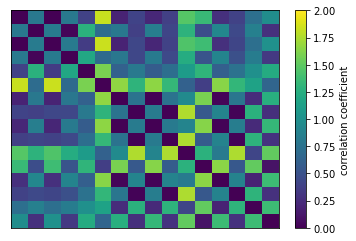

In [41]:
distance = RDM(hidden_activities, 'corr')
plot_corr_matrix(distance, vmax=2)

In [42]:
hidden_activities = np.vstack([
                                   TS1_PhaseA_hidden.mean(axis=0),
                                   TS2_PhaseA_hidden.mean(axis=0),
                                   TS1_PhaseB_hidden.mean(axis=0),
                                   TS2_PhaseB_hidden.mean(axis=0),
                                   Old_PhaseC_hidden.mean(axis=0),
                                   New_PhaseC_hidden.mean(axis=0)])

hidden_activities.shape

(6, 64)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


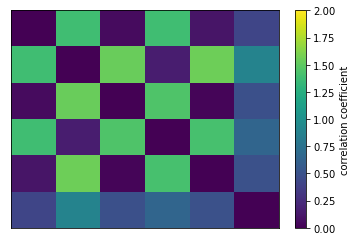

In [45]:
distance = RDM(hidden_activities, 'corr')
plot_corr_matrix(distance, vmax=2)